# Homework 5: Permutation Testing, Percentiles, and Bootstrapping

## Due Tuesday, May 23rd at 11:59PM

Welcome to Homework 5! This homework will cover:

- Permutation Testing (see [CIT 12.0-12.2](https://inferentialthinking.com/chapters/12/Comparing_Two_Samples.html))
- Percentiles (see [CIT 13.1](https://inferentialthinking.com/chapters/13/1/Percentiles.html))
- Bootstrapping and Confidence Intervals (see [CIT 13.2](https://inferentialthinking.com/chapters/13/2/Bootstrap.html) and [CIT 13.3](https://inferentialthinking.com/chapters/13/3/Confidence_Intervals.html))

### Instructions

Remember to start early and submit often. You are given six slip days throughout the quarter to extend deadlines. See the syllabus for more details. With the exception of using slip days, late work will not be accepted unless you have made special arrangements with your instructor.

**Important**: For homeworks, the `otter` tests don't usually tell you that your answer is correct. More often, they help catch careless mistakes. It's up to you to ensure that your answer is correct. If you're not sure, ask someone (not for the answer, but for some guidance about your approach). These are great questions for office hours (see the schedule on the [Calendar](https://dsc10.com/calendar)) or Ed. Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

In [21]:
# Don't change this cell; just run it. 
import babypandas as bpd
import numpy as np

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import otter
grader = otter.Notebook()

%reload_ext pandas_tutor

### Aside: Random Seeds 🌱

Throughout this homework – and in upcoming assignments – you'll notice that we frequently call the function `np.random.seed` with an integer argument. What exactly does that do?

To see for yourself, run the cell below several times.

In [22]:
np.random.seed(25)

print(np.random.multinomial(10, [0.5, 0.5]))
print(np.random.multinomial(10, [0.5, 0.5]))

[7 3]
[5 5]


`np.random.multinomial(10, [0.5, 0.5])` should return a random result each time it's called. However, each time you ran the cell above, you saw the same output – `[7 3]` and `[5 5]`.

**If you call `np.random.seed` in a cell, then every time you run the cell, you will see the same results, even if there are calls to "random" functions and methods in the cell.** Think of calling `np.random.seed` as "undoing" the randomness in the cell. If you change the `25` above to some other number, you may see something other than `[7 3]` and `[5 5]`, but each time you run the changed cell, you will still see the same result.

We use seeds to make it easier to autograde questions that rely on randomness, such as those that require you to bootstrap. When we use a particular seed in a question, we know exactly what the correct answer should be. When we don't, the range of correct answers is much wider, so it's harder to tell whether you actually answered the question correctly.

You're not responsible for understanding how seeds and random number generators work under the hood – all you need to know is that when you see a call to `np.random.seed`:
- Don't change it.
- Don't be alarmed if you see the same results each time you run that cell.

If you're interested in learning more, read [this Wikipedia article](https://en.wikipedia.org/wiki/Pseudorandom_number_generator).
<!-- It turns out that generating _truly_ random numbers is quite difficult. Instead, computers often generate _pseudorandom_ numbers, which are numbers that look like they were generated randomly (such as those in the cell above) but were actually generated by a complicated, non-random process. Each of these processes has a "key", or "seed," that determines the initial conditions for this non-random process. -->

## 1. Python vs Java 🐍☕

[Stack Overflow](https://stackoverflow.com/) is a forum where users can ask and answer questions about code. (If you've never used it before, you should use it as a resource!)

In this section, we'll work with a dataset of Stack Overflow questions from 2016 to 2020, downloaded from [Kaggle](https://www.kaggle.com/datasets/imoore/60k-stack-overflow-questions-with-quality-rate?resource=download&select=train.csv). The data has been cleaned and condensed for the purposes of this question.

The rideshare data contains six columns: `'Id'`, `'Title'`, `'Body'`, `'Tags'`, `'CreationDate'`, `'Ratings'`. Let's read it in and store it as a DataFrame called `stack_overflow`.

| Column | Description |
| --- | --- |
| `'Id'` | ID of the question |
| `'Title'` | Title of the question |
| `'Body'` | Description of the question |
| `'Tags'` | Tags used to categorize question |
| `'CreationDate'` | Date it was made |
| `'Ratings'` | Rating of the post |

In [23]:
stack_overflow = bpd.read_csv('data/stack_overflow.csv')
stack_overflow

,Id,Title,Body,Tags,CreationDate,Ratings
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT
...,...,...,...,...,...,...
14995,60465681,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,2020-02-29 13:32:56,LQ_CLOSE
14996,60467932,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,2020-02-29 17:46:41,LQ_CLOSE
14997,60468378,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,2020-02-29 18:35:39,LQ_EDIT
14998,60469392,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,2020-02-29 20:32:14,LQ_CLOSE


**Question 1.1.**
Stack Overflow gives users the ability to upvote or downvote questions and answers, which means that each post has a rating. **We're interested in exploring whether Python posts have higher ratings than Java posts.**

To determine the language of a post, we can look in the `'Tags'` column. The values in the `'Tags'` column contain several tags that are used to categorize posts. One of the tags for each post will be the language the post is about – for instance, in row 2 above, one of the tags for the post is `'<python>'`.

Below, assign `python_java` to a DataFrame that only contains questions that used the tags `'<python>'` or `'<java>'`. Don't worry about capitalization as all the tags have already been lowercased. Note that these questions may include other tags as well, as long as they have at least one of `'<python>'` or `'<java>'`.

*Hints:* 
- Use `str.contains`.
- There is a tag called `'<javascript>'`; make sure that is not in your final DataFrame.

In [24]:
#if ~ means not in. use and to take away a specfici thing

In [25]:
python_java = stack_overflow[stack_overflow.get('Tags').str.contains("python") |
                             stack_overflow.get('Tags').str.contains("java") & 
                             ~stack_overflow.get('Tags').str.contains("javascript")]
python_java

,Id,Title,Body,Tags,CreationDate,Ratings
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
9,34559136,Print list content in a given order,"<pre><code>lt = ['7,777.7', '777.7', '77,777.7...",<python><list><python-2.7><for-loop>,2016-01-01 19:08:12,LQ_CLOSE
13,34562473,Most Pythonic way to kill a thread after some ...,<p>I would like to run a process in a thread (...,<python><multithreading>,2016-01-02 04:01:41,HQ
16,34563454,Django ImageField upload_to path,<p>I'm having trouble understanding and using ...,<python><django>,2016-01-02 06:54:41,HQ
19,34564356,i am new to pythn and was trying to fix indent...,class Cylinder(object):\r\n self.pi = 3...,<python>,2016-01-02 09:22:24,LQ_EDIT
...,...,...,...,...,...,...
14986,60433781,Make this code shorter without using loops,<pre><code>import random\na = random.randrange...,<python><if-statement>,2020-02-27 12:56:18,LQ_CLOSE
14987,60434191,sort hashmap value of type list using java 8,<p>I have a map of String key and Value is Lis...,<java><arrays>,2020-02-27 13:20:20,LQ_CLOSE
14988,60436878,Sort python dictionary by value and the value ...,<p>I need to sort this dictionary by points: <...,<python><dictionary>,2020-02-27 15:44:19,LQ_CLOSE
14991,60451203,What is the name of the algorithm that can onl...,<p>I have tried googling this but no luck.</p>...,<python><algorithm><sorting>,2020-02-28 11:53:59,LQ_CLOSE


In [26]:
grader.check("q1_1")

q1_1 results: All test cases passed!

Upon further investigation, it looks like there are some posts that contain both the tags `'<python>'` and `'<java>'`. For the purposes of answering our question, we only want posts that have `'<python>'` or `'<java>'`, but not both. We've gone ahead and removed the posts that contained both tags and saved the resulting DataFrame to `fixed_python_java`, which you should use in Question 1.2.

In [27]:
# Don't change this cell; just run it.
fixed_python_java = python_java[python_java.get('Tags').str.contains('<python>') & python_java.get('Tags').str.contains('<java>') == False]
fixed_python_java

,Id,Title,Body,Tags,CreationDate,Ratings
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
9,34559136,Print list content in a given order,"<pre><code>lt = ['7,777.7', '777.7', '77,777.7...",<python><list><python-2.7><for-loop>,2016-01-01 19:08:12,LQ_CLOSE
13,34562473,Most Pythonic way to kill a thread after some ...,<p>I would like to run a process in a thread (...,<python><multithreading>,2016-01-02 04:01:41,HQ
16,34563454,Django ImageField upload_to path,<p>I'm having trouble understanding and using ...,<python><django>,2016-01-02 06:54:41,HQ
19,34564356,i am new to pythn and was trying to fix indent...,class Cylinder(object):\r\n self.pi = 3...,<python>,2016-01-02 09:22:24,LQ_EDIT
...,...,...,...,...,...,...
14986,60433781,Make this code shorter without using loops,<pre><code>import random\na = random.randrange...,<python><if-statement>,2020-02-27 12:56:18,LQ_CLOSE
14987,60434191,sort hashmap value of type list using java 8,<p>I have a map of String key and Value is Lis...,<java><arrays>,2020-02-27 13:20:20,LQ_CLOSE
14988,60436878,Sort python dictionary by value and the value ...,<p>I need to sort this dictionary by points: <...,<python><dictionary>,2020-02-27 15:44:19,LQ_CLOSE
14991,60451203,What is the name of the algorithm that can onl...,<p>I have tried googling this but no luck.</p>...,<python><algorithm><sorting>,2020-02-28 11:53:59,LQ_CLOSE


**Question 1.2.** Each post has associated with it many tags, but the only piece of information in the `'Tags'` column we're interested in is whether the language of the post is Python or Java.

Complete the implementation of the function `simplify_tag`, which takes in a string of tags associated with a single post and returns either `'Python'` or `'Java'`. Once you've done that, create a new DataFrame named `python_java_with_language` that has all the same columns as `fixed_python_java`, in the same order, with an additional column named `'CodingLanguage'` that contains the coding language associated with the post.

In [28]:
def simplify_tag(tag):
    if "<python>" in tag:
        return "Python"
    elif "<java>" in tag:
        return "Java"
    else:
        return None

# Create new DataFrame with 'CodingLanguage' column
python_java_with_language = fixed_python_java.assign(CodingLanguage=fixed_python_java.get('Tags').apply(simplify_tag))
python_java_with_language

,Id,Title,Body,Tags,CreationDate,Ratings,CodingLanguage
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ,Python
9,34559136,Print list content in a given order,"<pre><code>lt = ['7,777.7', '777.7', '77,777.7...",<python><list><python-2.7><for-loop>,2016-01-01 19:08:12,LQ_CLOSE,Python
13,34562473,Most Pythonic way to kill a thread after some ...,<p>I would like to run a process in a thread (...,<python><multithreading>,2016-01-02 04:01:41,HQ,Python
16,34563454,Django ImageField upload_to path,<p>I'm having trouble understanding and using ...,<python><django>,2016-01-02 06:54:41,HQ,Python
19,34564356,i am new to pythn and was trying to fix indent...,class Cylinder(object):\r\n self.pi = 3...,<python>,2016-01-02 09:22:24,LQ_EDIT,Python
...,...,...,...,...,...,...,...
14986,60433781,Make this code shorter without using loops,<pre><code>import random\na = random.randrange...,<python><if-statement>,2020-02-27 12:56:18,LQ_CLOSE,Python
14987,60434191,sort hashmap value of type list using java 8,<p>I have a map of String key and Value is Lis...,<java><arrays>,2020-02-27 13:20:20,LQ_CLOSE,Java
14988,60436878,Sort python dictionary by value and the value ...,<p>I need to sort this dictionary by points: <...,<python><dictionary>,2020-02-27 15:44:19,LQ_CLOSE,Python
14991,60451203,What is the name of the algorithm that can onl...,<p>I have tried googling this but no luck.</p>...,<python><algorithm><sorting>,2020-02-28 11:53:59,LQ_CLOSE,Python


In [29]:
grader.check("q1_2")

q1_2 results:
    q1_2 - 1 result:
        Trying:
            import numbers
        Expecting nothing
        ok
        Trying:
            python_java_with_language.shape == (3308, 7)
        Expecting:
            True
        **********************************************************************
        Line 2, in q1_2 0
        Failed example:
            python_java_with_language.shape == (3308, 7)
        Expected:
            True
        Got:
            False

    q1_2 - 2 result:
        Test case passed!

**Question 1.3.** As a reminder, we're interested in exploring whether Python posts have higher ratings than Java posts. In order to do that, we need to have ratings in the form of numbers, but right now, the `'Ratings'` column contains categorical values. The [Kaggle](https://www.kaggle.com/datasets/imoore/60k-stack-overflow-questions-with-quality-rate?resource=download&select=train.csv) page describes these values as follows: 

- `'HQ'`: High-quality posts without a single edit.
- `'LQ_EDIT'`: Low-quality posts with a negative score, and multiple community edits. However, they still remain open after those changes.
- `'LQ_CLOSE'`: Low-quality posts that were closed by the community without a single edit.

We're going to assign a numerical rating of `1` to low-quality posts (`'LQ_CLOSE'` and `'LQ_EDIT'`) and a numerical rating of `2` to high-quality posts (`'HQ'`).

Complete the implementation of the function `numerical_rating`, which takes in a **string** from the `'Ratings'` column and returns the corresponding numerical rating as described above. Once you've implemented `numerical_rating`, use it to replace the values in the `'Ratings'` column of `python_java_with_language` with the corresponding numerical ratings.

*Note*: Our solution is only two lines long, and one of the lines involves defining a dictionary. You don't have to use a dictionary in your implementation, but doing so will help keep your code concise!

In [30]:
# Just do the column equal to a new column to replace

In [31]:
def numerical_rating(rating):
    if "HQ" in rating:
        return 2
    elif "LQ_EDIT" or "LQ_CLOSE" in rating:
        return 1
    else:
        return None

python_java_with_language = python_java_with_language.assign(Ratings = python_java_with_language.get('Ratings').apply(numerical_rating))
python_java_with_language

,Id,Title,Body,Tags,CreationDate,Ratings,CodingLanguage
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,2,Python
9,34559136,Print list content in a given order,"<pre><code>lt = ['7,777.7', '777.7', '77,777.7...",<python><list><python-2.7><for-loop>,2016-01-01 19:08:12,1,Python
13,34562473,Most Pythonic way to kill a thread after some ...,<p>I would like to run a process in a thread (...,<python><multithreading>,2016-01-02 04:01:41,2,Python
16,34563454,Django ImageField upload_to path,<p>I'm having trouble understanding and using ...,<python><django>,2016-01-02 06:54:41,2,Python
19,34564356,i am new to pythn and was trying to fix indent...,class Cylinder(object):\r\n self.pi = 3...,<python>,2016-01-02 09:22:24,1,Python
...,...,...,...,...,...,...,...
14986,60433781,Make this code shorter without using loops,<pre><code>import random\na = random.randrange...,<python><if-statement>,2020-02-27 12:56:18,1,Python
14987,60434191,sort hashmap value of type list using java 8,<p>I have a map of String key and Value is Lis...,<java><arrays>,2020-02-27 13:20:20,1,Java
14988,60436878,Sort python dictionary by value and the value ...,<p>I need to sort this dictionary by points: <...,<python><dictionary>,2020-02-27 15:44:19,1,Python
14991,60451203,What is the name of the algorithm that can onl...,<p>I have tried googling this but no luck.</p>...,<python><algorithm><sorting>,2020-02-28 11:53:59,1,Python


In [32]:
grader.check("q1_3")

q1_3 results: All test cases passed!

**Question 1.4.** Using the DataFrame `python_java_with_language`, calculate the difference between the **mean** `'Rating'` of Python posts and Java posts. Assign your answer to `observed_difference`.

$$\text{observed difference} = \text{mean Python post rating} - \text{mean Java post rating}$$

In [33]:
python_posts = python_java_with_language[python_java_with_language.get('CodingLanguage') == 'Python']
mean_python_rating = python_posts.get("Ratings").mean()

java_posts = python_java_with_language[python_java_with_language.get('CodingLanguage') == 'Java']
mean_java_rating = java_posts.get("Ratings").mean()

observed_difference = mean_python_rating - mean_java_rating

observed_difference

0.1353065297006404

In [34]:
grader.check("q1_4")

q1_4 results: All test cases passed!

**Question 1.5.** What does the number you obtained for `observed_difference` mean? Assign `q1_4` to 1, 2, 3, or 4, corresponding to the best explanation below.

1. In our sample, the mean Python post rating is higher than the mean Java post rating by about 14 percent.
1. In our sample, the mean Python post rating is higher than the mean Java post rating by about 14 points.
1. In our sample, the mean Java post rating is higher than the mean Python post rating by about 14 percent.
1. In our sample, the mean Java post rating is higher than the mean Python post rating by about 14 points.

In [35]:
q1_4 = 2

In [36]:
grader.check("q1_5")

q1_5 results: All test cases passed!

Now we want to conduct a permutation test to see if it is by chance that the average rating for Python posts is higher than the average rating of Java posts in our sample, or if Python posts have a higher rating on average than Java posts.

- **Null Hypothesis**: The rating of Python posts and Java posts come from the same distribution.  
- **Alternative Hypothesis**: The rating of Python posts are higher on average than the rating of Java posts.

**Question 1.6.** Assign `python_java_rating` to a DataFrame with only two columns, `'CodingLanguage'` and `'Ratings'`, since these are the only relevant columns in `python_java_with_language` for this permutation test.

<!--
BEGIN QUESTION
name: q1_6
-->

In [37]:
python_java_rating = python_java_with_language.get(['CodingLanguage', 'Ratings'])
python_java_rating

,CodingLanguage,Ratings
2,Python,2
9,Python,1
13,Python,2
16,Python,2
19,Python,1
...,...,...
14986,Python,1
14987,Java,1
14988,Python,1
14991,Python,1


In [38]:
grader.check("q1_6")

q1_6 results:
    q1_6 - 1 result:
        Trying:
            python_java_rating.shape == (3308, 2)
        Expecting:
            True
        **********************************************************************
        Line 1, in q1_6 0
        Failed example:
            python_java_rating.shape == (3308, 2)
        Expected:
            True
        Got:
            False

**Question 1.7.** To perform the permutation test, 1000 times, create two random groups by shuffling the `'CodingLanguage'` column of `python_java_rating`. Don't change the `'Ratings'` column. For each pair of random groups, calculate the difference in mean ratings (Python minus Java) and store your 1000 differences in the `differences` array.  

*Note*: Since we are working with a relatively large data set, it may take **up to five minutes** to generate 1000 permutations. One suggestion is to make sure your code works correctly with fewer repetitions, say, 20, before using 1000 repetitions.

In [39]:
n_repetitions = 1000
differences = []

for _ in range(n_repetitions):
    shuffled_language = pd.DataFrame(python_java_rating.to_df().get('CodingLanguage').sample(frac=1).reset_index(drop=True))
    shuffled_df = python_java_rating.to_df().assign(CodingLanguage=shuffled_language['CodingLanguage'])
    python_mean = shuffled_df.loc[shuffled_df.get('CodingLanguage') == 'Python', 'Ratings'].mean()
    java_mean = shuffled_df.loc[shuffled_df.get('CodingLanguage') == 'Java', 'Ratings'].mean()
    differences.append(python_mean - java_mean)

differences = np.array(differences)

NameError: name 'pd' is not defined

In [40]:
grader.check("q1_7")

q1_7 results:
    q1_7 - 1 result:
        Trying:
            isinstance(differences, np.ndarray) and len(differences) == 1000
        Expecting:
            True
        **********************************************************************
        Line 1, in q1_7 0
        Failed example:
            isinstance(differences, np.ndarray) and len(differences) == 1000
        Expected:
            True
        Got:
            False

**Question 1.8.** Compute a p-value for this hypothesis test and assign your answer to `p_val`. To decide whether to use `<=` or `>=` in the calculation of the p-value, think about whether larger values or smaller values of our test statistic favor the alternative hypothesis.

In [41]:
python_ratings = python_java_rating.loc[python_java_rating.get('CodingLanguage') == 'Python'].get('Ratings').mean()
java_ratings = python_java_rating.loc[python_java_rating.get('CodingLanguage') == 'Java'].get('Ratings').mean()

observed_difference = python_ratings - java_ratings
p_val = np.count_nonzero(differences >= observed_difference) / n_repetitions
p_val


0.0

In [42]:
grader.check("q1_8")

q1_8 results: All test cases passed!

**Question 1.9.** Assign the variable `q1_9` to a **list** of all the true statements below.

1. We accept the null hypothesis at the 0.05 significance level.
2. We reject the null hypothesis at the 0.01 significance level.
3. We fail to reject the null hypothesis at the 0.01 significance level.
4. We accept the null hypothesis at the 0.01 significance level.
5. We fail to reject the null hypothesis at the 0.05 significance level.
6. We reject the null hypothesis at the 0.05 significance level.

In [43]:
q1_9 = q1_9 = [1, 3, 6]

In [44]:
grader.check("q1_9")

q1_9 results: All test cases passed!

**Question 1.10.** Suppose in this question you had shuffled the `'Ratings'` column instead and kept the `'CodingLanguage'` column in the same order. Assign `q1_10` to either 1, 2, 3, or 4, corresponding to the true statement below.


1. The new p-value from shuffling `'Ratings'` would be $1 - p$, where $p$ is the old p-value from shuffling `'CodingLanguage'` (i.e. your answer to Question 1.8).
2. We would need to change our null hypothesis in order to shuffle the `'Ratings'` column. 
3. There would be no difference in the conclusion of the test if we had shuffled the `'Ratings'` column instead.
4. The `'Ratings'` column cannot be shuffled because it contains numbers.

In [45]:
q1_10 = 2

In [46]:
grader.check("q1_10")

q1_10 results: All test cases passed!

**Question 1.11.** Which of the following choices best describes the purpose of shuffling one of the columns in our dataset in a permutation test? Assign `q1_11` to either 1, 2, 3, or 4.

1. Shuffling mitigates noise in our data by generating new permutations of the data.
1. Shuffling is a special case of bootstrapping and allows us to produce interval estimates.
1. Shuffling allows us to generate new data under the null hypothesis, which we can use in testing our hypothesis.
1. Shuffling allows us to generate new data under the alternative hypothesis, which explains that the data come from different distributions.

In [47]:
q1_11 = 3

In [48]:
grader.check("q1_11")

q1_11 results: All test cases passed!

## 2. Video Game Price Percentiles 🎮

Percentiles associate numbers in a dataset to their positions when the dataset is sorted in ascending order. You may be familiar with the idea of percentiles from height and weight measurements at the doctor's office, or from standardized test scores.

There are many different ways to precisely define a percentile. In [Lecture 19](https://dsc10.com/resources/lectures/lec19/lec19.html#Percentiles), we saw two different approaches:
- Using a mathematical definition (see the slide in Lecture 19 titled _[How to calculate percentiles using the mathematical definition](https://dsc10.com/resources/lectures/lec19/lec10.html#How-to-calculate-percentiles-using-the-mathematical-definition)_).
- Using `np.percentile`.

In Questions 2.1 through 2.4, we will use the mathematical definition, and in Question 2.5, we will use `np.percentile`.

The file `steam_games.csv` contains information about various games sold on the online video game store and distribution service [Steam](https://store.steampowered.com/). The data comes from [Kaggle](https://www.kaggle.com/datasets/thedevastator/get-your-game-on-metacritic-recommendations-and?resource=download).

The columns are:
- `'Game'`: The name of the video game
- `'ReleaseDate'`: The date it was released
- `'Metacritic'`: The review score it earned on [metacritic.com](https://www.metacritic.com/), or 0 if it's not reviewed
- `'RecommendationCount'`: Number of times it has been recommended in Steam 
- `'IsFree'`: Whether the game is free or not
- `'GenreIsXXX'`:  Whether the game belongs to genre XXX (many such columns)
- `'Price'`: The price of the game when it was initially released

Let's read in the data and explore the full set of column names.

In [49]:
steam = bpd.read_csv('data/steam_games.csv')
steam

,Game,ReleaseDate,Metacritic,RecommendationCount,IsFree,GenreIsNonGame,GenreIsIndie,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsStrategy,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports,GenreIsRacing,GenreIsMassivelyMultiplayer,Price
0,Counter-Strike,Nov 1 2000,88,68991,False,False,False,True,False,False,False,False,False,False,False,False,False,False,9.99
1,Team Fortress Classic,Apr 1 1999,0,2439,False,False,False,True,False,False,False,False,False,False,False,False,False,False,4.99
2,Day of Defeat,May 1 2003,79,2319,False,False,False,True,False,False,False,False,False,False,False,False,False,False,4.99
3,Deathmatch Classic,Jun 1 2001,0,888,False,False,False,True,False,False,False,False,False,False,False,False,False,False,4.99
4,Half-Life: Opposing Force,Nov 1 1999,0,2934,False,False,False,True,False,False,False,False,False,False,False,False,False,False,4.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12618,VR RunningJoe,Oct 31 2016,0,0,False,False,False,False,False,True,False,False,False,False,False,False,True,False,0.00
12619,ObserVR Beta,Oct 26 2016,0,0,True,True,False,False,False,False,False,False,False,True,False,False,False,False,0.00
12620,Fiber Twig: Midnight Puzzle,Oct 26 2016,0,0,False,False,True,False,False,True,False,False,False,False,False,False,False,False,2.99
12621,Charm Tale Quest,Oct 27 2016,0,0,False,False,True,False,False,True,False,False,False,False,False,False,False,False,2.99


**Question 2.1.** Pick the best choice of bins below for a histogram showing the distribution of `'Price'`, then create the histogram. Make sure all the data is included!

Use one of the following:

- `rating_bins = np.arange(0, 100, 10)`
- `rating_bins = np.arange(0, 200, 10)`
- `rating_bins = np.arange(0, 500, 10)`
- `rating_bins = np.arange(0, 700, 10)`

<AxesSubplot:ylabel='Frequency'>

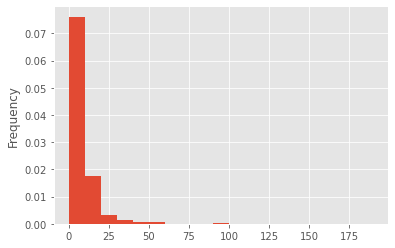

In [50]:
rating_bins = max_price = steam.get('Price').max()


# Now create a density histogram showing the distribution of rating using rating_bins
bins_range = np.arange(0, 200, 10) # Change this as necessary
steam.get('Price').plot(kind='hist', bins=bins_range, density=True)


Some games are marked as not free according to the `'IsFree'` column, yet their `'Price'` is listed as 0. This is likely due to the game having a page on the Steam website before it was readily available to be purchased. We'll say that a game is a *paid game* if both `'IsFree'` is `False` and `'Price'` is nonzero.

For the paid games only, let's compare the prices of indie games and non-indie games. An indie (short for independent) game is one that has been developed by an individual or small team as opposed to a large studio.

Run the cell below to create a DataFrame of paid games that are not indie games, and a sorted array of their prices.

In [51]:
paid_not_indie_df = steam[(steam.get('GenreIsIndie') == False) & 
                          (steam.get('IsFree') == False) & 
                          (steam.get('Price') != 0)]
paid_not_indie_prices  = paid_not_indie_df.get('Price')
paid_not_indie_prices = np.sort(paid_not_indie_prices)
paid_not_indie_prices

array([  0.9 ,   0.99,   0.99, ..., 399.  , 399.99, 449.99])

**Question 2.2.** Calculate the 63rd percentile of `paid_not_indie_prices` using the [mathematical definition](https://dsc10.com/resources/lectures/lec19/lec19.html#How-to-calculate-percentiles-using-the-mathematical-definition) given in Lecture 19. That is:
- Set `n` to be the number of elements in `paid_not_indie_prices`. 
- Set `k` to be the smallest integer greater than or equal to $\frac {63}{100} \cdot n$. 
- Assign the 47rd percentile of the array `paid_not_indie_prices` to `paid_not_indie_prices_63rd`.

You must use the variables provided for you when solving this problem. For this problem, **do not** use `np.percentile`.

In [52]:
is_not_indie = steam.get('GenreIsIndie') == False
is_not_free = steam.get('IsFree') == False
has_price = steam.get('Price') != 0

paid_not_indie_df = steam.loc[is_not_indie & is_not_free & has_price]

paid_not_indie_prices = paid_not_indie_df.get('Price').values
paid_not_indie_prices = np.sort(paid_not_indie_prices)

n = len(paid_not_indie_prices)
k = int(np.ceil(63/100 * n))

paid_not_indie_prices_63rd = paid_not_indie_prices[k-1]


In [53]:
grader.check("q2_2")

q2_2 results: All test cases passed!

**Question 2.3.** Now we'll compare the value we just calculated with the 63rd percentile of the prices of non-free **indie** games.

Create a DataFrame called `paid_indie_df` containing only the paid games that belong to the indie genre. Calculate the 63rd percentile of prices for these games, using the same mathematical procedure. Assign to the variable `absolute_difference` the absolute difference in the 63rd percentile of prices for paid indie games and paid non-indie games.

As before, use the variables provided and **do not** use `np.percentile`.

*Hint*:  Remember to sort the prices using `np.sort` before computing percentiles.

In [54]:
# Create Boolean Series for filter
is_indie = steam.get('GenreIsIndie') == True
is_not_free = steam.get('IsFree') == False
has_price = steam.get('Price') != 0

# Apply filter using loc
paid_indie_df = steam.loc[is_indie & is_not_free & has_price]

paid_indie_prices = paid_indie_df.get('Price').values
paid_indie_prices = np.sort(paid_indie_prices)

n_2 = len(paid_indie_prices)
k_2 = int(np.ceil(63/100 * n_2))

paid_indie_prices_63rd = paid_indie_prices[k_2-1]

absolute_difference = abs(paid_not_indie_prices_63rd - paid_indie_prices_63rd)


In [55]:
grader.check("q2_3")

q2_3 results: All test cases passed!

**Question 2.4.** Say that UCSD is developing a new game where students will be able to create custom avatars of themselves and take classes at a virtual UCSD. The university decides to set the price of this new game at 15 dollars and then advertise it as a great bargain for an excellent education.

This game is one that is: 
- Not free.
- Still in early access (that is, not finished yet).
- Massively multiplayer.
- Not indie.

Consider a new collection of values, containing the prices of all the games that share these characteristics, plus one more, $15 for UCSD's game:

In [56]:
new_collection_df = steam[(steam.get('IsFree') == False) & 
                          (steam.get('Price') != 0 ) & 
                          (steam.get('GenreIsEarlyAccess') == True ) &  
                          (steam.get('GenreIsMassivelyMultiplayer') == True ) & 
                          (steam.get('GenreIsIndie') == False)]
new_collection = np.array(new_collection_df.get('Price'))
new_collection = np.sort(np.append(new_collection, 15))
new_collection

array([ 3.99,  4.99,  4.99,  5.99,  9.99,  9.99, 14.99, 14.99, 14.99,
       15.  , 17.99, 19.99, 19.99, 19.99, 19.99, 29.99, 29.99, 29.99,
       34.99, 39.99, 39.99])

For what integer values of $p$ would we be able to say that this new collection of values has 15 as its $p$th percentile? Create a **list** called `percentile_range` of all integer values of $p$ such that the $p$th percentile of the new collection equals 15, according to the **mathematical** definition of percentile. 

This is a math question, not a coding question. You should create the list `percentile_range` manually, by solving a math problem on paper and inputting your answer in the form of a Python list.

**Do not use `np.percentile`.**

In [57]:
percentile_range = [48]

In [58]:
grader.check("q2_4")

q2_4 results: All test cases passed!

**Question 2.5**. The first _quartile_ of a numerical collection is the 25th percentile, the second quartile is the 50th percentile, and the third quartile is the 75th percentile. Quartiles are so named because they divide the collection into quarters.

Make a list called `price_quartiles` that contains the values for the first, second, and third quartiles (in that order) of the `'Price'` data provided in `steam`. For this problem, calculate the percentiles **using `np.percentile`**.

In [59]:
price_quartiles = list(np.percentile(steam.get('Price'), [25, 50, 75]))
price_quartiles

[1.99, 5.99, 9.99]

In [60]:
grader.check("q2_5")

q2_5 results: All test cases passed!

## 3. Live Crystal Scoops 🔮

<center><img src='images/crystals.jpg' width=30%>(<a href="https://www.youtube.com/watch?v=JHdKb-LumRk">source</a>)</center>

Over the last year, _live crystal scoops_ have become popular on TikTok. There are TikTok pages that collect and sell [crystals](https://en.wikipedia.org/wiki/Crystal), which some believe have the power to heal both the body and the mind. These pages don't sell crystals individually, but rather they "scoop" a random collection of their inventory, put the collected crystals in a bag, and send that bag to the customer. What makes them _live_ crystal scoops is that these pages typically livestream the act of scooping these crystals for every order they receive and include the order number in the stream, so that customers can verify that what they receive is actually what was scooped. For instance, [@chloesmith.uk](https://www.tiktok.com/@chloesmith.uk) is one such page.

Last night, you were scrolling endlessly on TikTok, and came across crystal scooping livestreams by two accounts, _Scoops by Shelly_ and _Crystals by Cathy_. Both are selling scoops for $29.99. Intrigued, you decide to order a scoop from Cathy, and in the livestream it seems that you pulled a hefty scoop. When your order is finally delivered, however, you're disappointed to find that the total weight of the crystals you received is much lower than what you expected given what you saw on the livestream. Should you have purchased a scoop from Shelly instead?

**Question 3.1.** Ideally, you want to determine the mean weight of **all** scoops from *Crystals by Cathy*. However, it's not feasible to do so, because her scoops are very expensive and she has many other customers. Instead, you will collect a sample of scoops to obtain a ____________ statistic to estimate this ____________ parameter.

Complete the sentence above by filling in the blanks. Set `q3_1` to 1, 2, 3, or 4.

1. sample; population
2. test; sample
3. population; sample
4. test; population

In [61]:
q3_1 = 1

In [62]:
grader.check("q3_1")

q3_1 results: All test cases passed!

Fortunately, you have an incredible crystal resource at your disposal, the [Crystals Live Share Group](https://www.facebook.com/groups/846961549165998) on Facebook. You make a post and ask the members who've bought scoops from *Scoops by Shelly* and *Crystals by Cathy* to weigh their packages in grams. You're overwhelmed by the amazing community response and receive 80 different scoop weights in total from other buyers, 40 from *Scoops by Shelly* buyers and 40 from *Crystals by Cathy* buyers.  

Let's look at all the data that you crowdsourced. Each entry in the `'Weight'` column represents the weight of one scoop, in grams.

In [63]:
crystal_weights = bpd.read_csv('data/crystals.csv')
crystal_weights

,Seller,Weight
0,Scoops by Shelly,224.26
1,Scoops by Shelly,298.35
2,Scoops by Shelly,259.49
3,Scoops by Shelly,371.21
4,Scoops by Shelly,296.12
...,...,...
75,Crystals by Cathy,448.93
76,Crystals by Cathy,403.07
77,Crystals by Cathy,480.70
78,Crystals by Cathy,382.05


**Question 3.2.** To start, we'll look at only the scoops in our sample from *Crystals by Cathy*. Below, assign `cathy_crystals` to a DataFrame with only the scoops from *Crystals by Cathy*. Then, assign `cathy_mean` to the mean weight of the *Crystals by Cathy* scoops in our sample.

In [64]:
cathy_crystals = crystal_weights[crystal_weights.get('Seller') == 'Crystals by Cathy']
cathy_mean = cathy_crystals.get('Weight').mean()

cathy_mean

402.823

In [65]:
grader.check("q3_2")

q3_2 results: All test cases passed!

You're done! Or are you? You have a single estimate for the true mean weight of Cathy's scoops. However, you don't know how close that estimate is, or how much it could have varied if you'd had a different sample. In other words, you have an estimate, but no understanding of how close that estimate is to the true mean weight of *all* of Cathy's scoops.

This is where the idea of resampling via **[bootstrapping](https://inferentialthinking.com/chapters/13/2/Bootstrap.html)** comes in. Assuming that our sample resembles the population fairly well, we can resample from our original sample to produce more samples. From each of these resamples, we can produce another estimate for the true mean weight, which gives us a distribution of sample means that describes how the estimate might vary given different samples. We can then use this distribution to produce an interval that estimates the true mean weight of Cathy's scoops.

**Question 3.3.** Complete the following code to produce 1000 bootstrapped estimates for the mean weight of Cathy's scoops. Store your 1000 estimates in an array called `resample_means`.

In [66]:
resample_means = np.array([])
for i in np.arange(1000):
    resample = cathy_crystals.sample(n=len(cathy_crystals.get('Weight')), replace=True)
    resample_mean = resample.get('Weight').mean()
    resample_means = np.append(resample_means, resample_mean)

resample_means

array([413.294  , 404.775  , 402.23225, 406.97875, 405.9815 , 412.18425,
       412.1445 , 394.0315 , 402.268  , 407.5055 , 418.88875, 408.95675,
       401.5015 , 399.23625, 391.98375, 401.42675, 402.132  , 396.038  ,
       395.9005 , 404.59925, 399.84275, 394.156  , 394.659  , 404.598  ,
       414.7475 , 404.57725, 398.93175, 394.00875, 403.09975, 393.7225 ,
       406.22975, 412.99925, 405.6135 , 394.47225, 402.1865 , 413.48875,
       408.0365 , 408.65925, 401.35725, 413.17475, 412.092  , 384.97525,
       392.0285 , 407.787  , 416.9125 , 397.834  , 410.50425, 397.6885 ,
       417.55975, 392.283  , 392.817  , 415.02275, 403.868  , 390.4335 ,
       387.69075, 405.92   , 395.53575, 403.0805 , 399.15725, 405.604  ,
       402.0275 , 415.5955 , 403.571  , 408.30975, 408.09925, 408.014  ,
       416.30675, 388.357  , 395.579  , 405.9025 , 400.7545 , 406.86775,
       391.13775, 400.82225, 408.767  , 398.9425 , 403.68425, 388.8605 ,
       398.8515 , 407.39575, 409.77425, 399.49525, 

In [67]:
grader.check("q3_3")

q3_3 results: All test cases passed!

Let's look at the distribution of your estimates:

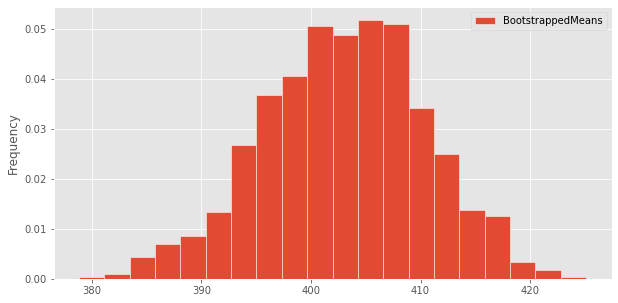

In [68]:
bpd.DataFrame().assign(BootstrappedMeans = resample_means).plot(kind='hist', density=True, ec='w', bins=20, figsize=(10, 5));

**Question 3.4.** Using the array `resample_means`, compute an approximate 95% confidence interval for the true mean weight of Cathy's scoops. Save the lower and upper bounds of the interval as `cathy_lower_bound` and `cathy_upper_bound`, respectively.

*Hint*: Use `np.percentile`.

In [69]:
cathy_lower_bound = np.percentile(resample_means, 2.5)
cathy_upper_bound = np.percentile(resample_means, 97.5)

# Print the confidence interval.
print("Bootstrapped 95% confidence interval for the true mean weight of Cathy's scoops: [{:f}, {:f}]".format(cathy_lower_bound, cathy_upper_bound))

Bootstrapped 95% confidence interval for the true mean weight of Cathy's scoops: [387.963188, 417.225375]


In [70]:
grader.check("q3_4")

q3_4 results: All test cases passed!

**Question 3.5.** Which of the following would likely make the histogram from Question 3.3 wider? If you believe more than one would, choose the answer with the most substantial effect. Assign to `q3_5` either 1, 2, 3, or 4.

1. Increasing the number of resamples (repetitions of the bootstrap) to 3000.
1. Decreasing the number of resamples (repetitions of the bootstrap) to 500.
1. Starting with a larger sample of 100 scoops.
1. Starting with a smaller sample of 20 scoops.

In [71]:
q3_5 = 4
q3_5

4

In [72]:
grader.check("q3_5")

q3_5 results: All test cases passed!

**Question 3.6.** Suppose you want to estimate the weight of the lightest scoop Cathy has ever scooped, her biggest scam. Would bootstrapping be effective in estimating this weight? Assign `bootstrapping_effective` to either `True` or `False`, representing your answer.

In [73]:
bootstrapping_effective = False

In [74]:
grader.check("q3_6")

q3_6 results: All test cases passed!

**Question 3.7.** Now let's address a different question: how does the average weight of a *Scoops by Shelly* scoop compare to the average weight of a *Crystals by Cathy* scoop? Create a DataFrame called `shelly_scoops` that contains only the weights of scoops from *Scoops by Shelly*, and set `shelly_mean` equal to the mean weight of Shelly's scoops as you did for *Crystals by Cathy* in Question 3.2. Then, set `observed_diff_mean` to the difference in mean scoop weight for the Cathy and Shelly's scoops in our sample.

$$\text{difference} = \text{mean weight of Cathy's scoops} - \text{mean weight of Shelly's scoops}$$

In [75]:
shelly_scoops = crystal_weights[crystal_weights.get('Seller') == 'Scoops by Shelly']
shelly_mean = shelly_scoops.get('Weight').mean()
observed_diff_mean = cathy_mean - shelly_mean
observed_diff_mean

88.43224999999995

In [76]:
grader.check("q3_7")

q3_7 results: All test cases passed!

If you completed Question 3.7 correctly, you should have found that Shelly and Cathy's mean scoop weights were quite different. Remember, all we have access to are samples of size 40 from each seller. Would we see this large of a difference if we had access to the population – that is, the weights of all scoops ever produced by both sellers – or was it just by chance that our samples displayed this difference? Let's do a **hypothesis test** to find out. We'll state our hypotheses as follows:

- **Null Hypothesis**: The mean weight of scoops from *Crystals by Cathy* is equal to the mean weight of scoops from *Scoops by Shelly*. Equivalently, the difference in the mean scoop weight for the two sellers equals 0 grams.

- **Alternative Hypothesis**: The mean weight of scoops from *Crystals by Cathy* is not equal to the mean weight of scoops from *Scoops by Shelly*. Equivalently, the difference in the mean scoop weight for the two sellers does not equal 0 grams.

Since we were able to set up our hypothesis test as a question of whether a certain population parameter – the difference in mean scoop weight for *Crystals by Cathy* and *Scoops by Shelly* – is equal to a certain value, we can **test our hypotheses by constructing a confidence interval** for the parameter. This is the method we used in [Lecture 20](https://dsc10.com/resources/lectures/lec20/lec20.html). You can read more about conducting a hypothesis test with a confidence interval in [CIT 13.4](https://inferentialthinking.com/chapters/13/4/Using_Confidence_Intervals.html).

*Note*: We are not conducting a permutation test here, although that would also be a valid approach to test these hypotheses.

**Question 3.8.** Compute 1000 bootstrapped estimates for the difference in the mean scoop weight for *Scoops by Shelly* and *Crystals by Cathy*. As in Question 3.7, do Cathy minus Shelly. Store your 1000 estimates in the `difference_means` array.

You should generate your Shelly resamples by sampling from `shelly_scoops`, and your Cathy resamples by sampling from `cathy_crystals`. You should not use `crystal_weights` at all.

In [77]:
np.random.seed(23) # Ignore this, and don't change it.

difference_means = np.array([])
for i in np.arange(1000):
    resample_shelly = shelly_scoops.sample(n=shelly_scoops.shape[0], replace=True)
    resample_cathy = cathy_crystals.sample(n=cathy_crystals.shape[0], replace=True)
    resample_mean_diff = resample_cathy.get('Weight').mean() - resample_shelly.get('Weight').mean()
    difference_means = np.append(difference_means, resample_mean_diff)
    

# Just display the first ten differences.
difference_means[:10]

array([ 78.70525,  93.47725,  93.79975, 126.55325,  65.628  ,  86.71875,
       104.98375,  92.31425,  60.486  ,  92.91175])

In [78]:
grader.check("q3_8")

q3_8 results: All test cases passed!

Let's visualize your estimates:

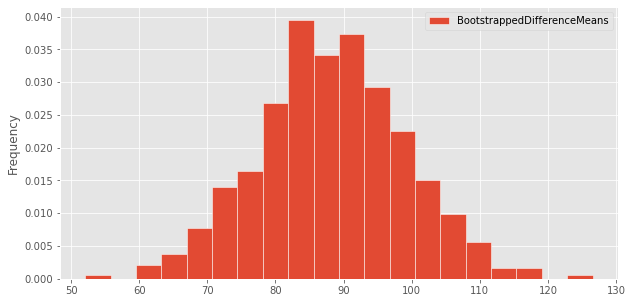

In [79]:
bpd.DataFrame().assign(BootstrappedDifferenceMeans = difference_means).plot(kind = 'hist', density=True, ec='w', bins=20, figsize=(10, 5));

**Question 3.9.** Compute a 95% confidence interval for the difference in mean weights of Shelly and Cathy's scoops (as before, Cathy minus Shelly). Assign the left and right endpoints of this confidence interval to `left_endpoint` and `right_endpoint` respectively. Use `np.percentile` to find the endpoints.

In [80]:
left_endpoint = np.percentile(difference_means, 2.5)
right_endpoint = np.percentile(difference_means, 97.5)

print("Bootstrapped 95% confidence interval for the mean difference in weights of Shelly and Cathy's scoops:\n [{:f}, {:f}]".format(left_endpoint, right_endpoint))

Bootstrapped 95% confidence interval for the mean difference in weights of Shelly and Cathy's scoops:
 [67.133513, 109.333006]


In [81]:
grader.check("q3_9")

q3_9 results: All test cases passed!

**Question 3.10.** Based on the confidence interval you've created, would you reject the null hypothesis at the 0.05 significance level? Set `reject_null` to True if you would reject the null hypothesis, and False if you would not.

In [82]:
reject_null = 0 < left_endpoint or 0 > right_endpoint

In [83]:
grader.check("q3_10")

q3_10 results: All test cases passed!

**Question 3.11.** What if the Facebook group members had recorded all of their scoop weights in pounds instead of grams? Would your hypothesis test still come to the same conclusion either way? Set `same_conclusion` to True or False.

In [84]:
same_conclusion = True

In [85]:
grader.check("q3_11")

q3_11 results: All test cases passed!

## 4. Chocolate Shop  🍫

You are planning to open a chocolate shop and you want to get a sense of the local residents' chocolate preferences. You survey 510 randomly-selected local residents and ask which type of chocolate they prefer the most among four options – `'dark'`, `'milk'`, `'white'`, `'bittersweet'`. You also record some indecisive individuals as `'undecided'`.

Run the next cell to load in the results of the survey.

In [86]:
chocolate = bpd.read_csv('data/chocolate.csv')
chocolate

,chocolate
0,dark
1,milk
2,white
3,white
4,undecided
...,...
505,white
506,dark
507,bittersweet
508,white


Assume that your sample is a uniform random sample of the local population. Below, we compute the proportion of people in your sample that prefer each type of chocolate.

In [87]:
chocolate.assign(counts=chocolate.get('chocolate')).groupby('chocolate').count().get('counts') / chocolate.shape[0]

chocolate
bittersweet    0.060784
dark           0.282353
milk           0.237255
undecided      0.100000
white          0.319608
Name: counts, dtype: float64

What you're truly interested in, though, is the proportion of *all local residents* that prefer each type of chocolate. These are *population parameters* (plural, because there are 5 proportions).

In this question, we will start by computing a confidence interval for the true proportion of residents that prefer `'dark'` chocolate, and then later compute a confidence interval for the true difference in proportions of residents that prefer `'dark'` chocolate over `'milk'` chocolate. 

<center><img src="images/choco-pun.jpeg" width=35%></center>


Below, we have given you code that computes 1000 bootstrapped estimates of the true proportion of residents who prefer `'dark'` chocolate over the other options. Run the next cell to calculate these estimates and display a histogram of their values.

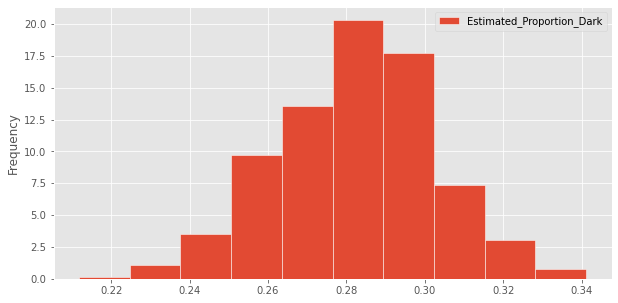

In [88]:
def proportions_in_resamples():
    np.random.seed(55) # Ignore this, and don't change it.
    num_residents = chocolate.shape[0]
    proportions = np.array([])
    for i in np.arange(1000):
        resample = chocolate.sample(num_residents, replace = True)
        resample_proportion = np.count_nonzero(resample.get('chocolate') == 'dark') / num_residents
        proportions = np.append(proportions, resample_proportion)
    return proportions

boot_dark_proportions = proportions_in_resamples()
bpd.DataFrame().assign(Estimated_Proportion_Dark=boot_dark_proportions).plot(kind='hist', density=True, ec='w', figsize=(10, 5));

**Question 4.1.** Using the array `boot_dark_proportions`, compute an approximate **99%** (not 95%) confidence interval for the true proportion of residents who prefer `'dark'` chocolate.  Compute the lower and upper ends of the interval, named `dark_lower_bound` and `dark_upper_bound`, respectively.

*Note*: As we did in lecture, use `np.percentile` whenever computing confidence intervals.

In [89]:
dark_lower_bound = np.percentile(boot_dark_proportions, 0.5)
dark_upper_bound = np.percentile(boot_dark_proportions, 99.5)

# Print the confidence interval:
print("Bootstrapped 99% confidence interval for the true proportion of residents who prefer dark chocolate in the population:\n[{:f}, {:f}]".format(dark_lower_bound, dark_upper_bound))

Bootstrapped 99% confidence interval for the true proportion of residents who prefer dark chocolate in the population:
[0.231373, 0.335304]


In [90]:
grader.check("q4_1")

q4_1 results: All test cases passed!

**Question 4.2.**
Is it true that 99% of the population lies in the range `dark_lower_bound` to `dark_upper_bound`? Assign the variable `q4_2` to either `True` or `False`. 

In [91]:
q4_2 = False

In [92]:
grader.check("q4_2")

q4_2 results: All test cases passed!

**Question 4.3.**
Is it true that the true proportion of residents who prefer `'dark'` chocolate over the other chocolates is a random quantity with approximately a 99% chance of falling between `dark_lower_bound` and `dark_upper_bound`? Assign the variable `q4_3` to either `True` or `False`.

In [93]:
q4_3 = False

In [94]:
grader.check("q4_3")

q4_3 results: All test cases passed!

**Question 4.4.**
Suppose we were somehow able to produce 20,000 new samples, each one a uniform random sample of 510 residents taken directly from the population. For each of those 20,000 new samples, we create a 99% confidence interval for the proportion of residents who prefer `'dark'` chocolate. Roughly how many of those 20,000 intervals should we expect to actually contain the true proportion of the population? Assign your answer to the variable `how_many` below. It should be of type `int`, representing the *number* of intervals, not the proportion or percentage.

In [95]:
how_many = int(0.99 * 20000)
how_many

19800

In [96]:
grader.check("q4_4")

q4_4 results: All test cases passed!

**Question 4.5.** We also created 90%, 95%, and 99.9% confidence intervals from one sample (shown below), but forgot to label which confidence intervals were which! Match the interval to the percent of confidence the interval represents and assign your choices (either 1, 2, or 3) to variables `ci_90`, `ci_95`, and `ci_999`, corresponding to the 90%, 95%, and 99.9% confidence intervals respectively.

*Hint*: Drawing the confidence intervals out on paper might help you visualize them better.

1. $[0.273, 0.363]$


2. $[0.268, 0.380]$


3. $[0.295, 0.354]$


In [97]:
ci_90 = 2
ci_95 = 1
ci_999 = 3
ci_90, ci_95, ci_999

(2, 1, 3)

In [98]:
grader.check("q4_5")

q4_5 results: All test cases passed!

**Question 4.6.** Based on the survey results shown at the start of the question, it seems that `'dark'` chocolate is more popular than `'milk'` chocolate among residents. We would like to construct a range of likely values – that is, a confidence interval – for the difference in popularity, which we define as:

$$\text{(Proportion of residents who prefer dark chocolate)} - \text{(Proportion of residents who prefer milk chocolate)}$$

Create a function, `differences_in_resamples`, that creates **1000 bootstrapped resamples of the original survey data** in the `chocolate` DataFrame, computes the difference in proportions for each resample, and returns an array of these differences. Store your bootstrapped estimates in an array called `boot_differences` and plot a histogram of these estimates.

*Note*: While this might sound like a job for permutation testing, this is instead a bootstrapping question. Note that our goal is to estimate a population parameter – the difference between the proportion of all residents that prefer dark chocolate and the proportion of all residents that prefer milk chocolate – not to answer a question about whether two samples come from the same distribution.

*Hint*: Use the code for `proportions_in_resamples` given to you above as a starting point.

<AxesSubplot:ylabel='Frequency'>

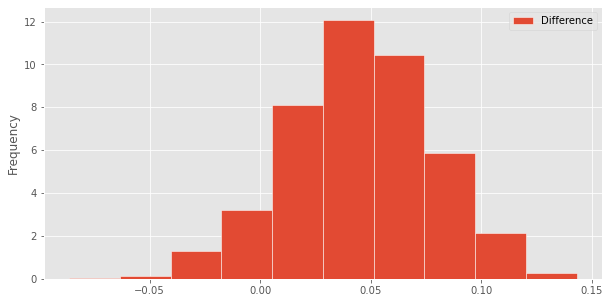

In [99]:
def differences_in_resamples():
    np.random.seed(55) # Ignore this, and don't change it.
    differences = np.array([])
    num_residents = chocolate.shape[0]

    for _ in range(1000):
        bootstrap = chocolate.sample(n=num_residents, replace=True)
        dark_proportion = (bootstrap.get('chocolate') == 'dark').mean()
        milk_proportion = (bootstrap.get('chocolate') == 'milk').mean()
        difference = dark_proportion - milk_proportion
        differences = np.append(differences, difference)

    return differences

boot_differences = differences_in_resamples()

# Plotting the histogram
bpd.DataFrame().assign(Difference=boot_differences).plot(kind='hist', density=True, ec='w', figsize=(10, 5))


In [100]:
grader.check("q4_6")

q4_6 results: All test cases passed!

**Question 4.7.** Compute an approximate 99% confidence interval for the difference in proportions. Assign the lower and upper bounds of the interval to `diff_lower_bound` and `diff_upper_bound`, respectively.

In [101]:
diff_lower_bound = np.percentile(boot_differences, 0.5)
diff_upper_bound = np.percentile(boot_differences, 99.5)


# Print the confidence interval:
print("Bootstrapped 99% confidence interval for the difference in popularity between dark chocolate and milk chocolate:\n[{:f}, {:f}]".format(diff_lower_bound, diff_upper_bound))

Bootstrapped 99% confidence interval for the difference in popularity between dark chocolate and milk chocolate:
[-0.037265, 0.123549]


In [102]:
grader.check("q4_7")

q4_7 results: All test cases passed!

**Question 4.8.** In this question, you computed two 99% confidence intervals:
- In Question 4.1, you found a 99% confidence interval for the proportion of residents who prefer `'dark'` chocolate among the four chocolate options. Let's call this the "dark chocolate CI."
- In Question 4.7, you found a 99% confidence interval for the difference between the proportion of residents who prefer `'dark'` chocolate and the proportion of residents who prefer `'milk'` chocolate. Let's call this the "difference CI." 

Which of the explanations below best describes the widths of these two confidence intervals? Set `q4_8` to either 1, 2, 3, or 4.

1. The dark chocolate CI is **wider** than the difference CI because we have **more certainty** in an estimate of a single unknown parameter than in the difference between two unknown parameters.
1. The dark chocolate CI is **narrower** than the difference CI because we have **more certainty** in an estimate of a single unknown parameter than in the difference between two unknown parameters.
1. The dark chocolate CI is **wider** than the difference CI because we have **less certainty** in an estimate of a single unknown parameter than in the difference between two unknown parameters.
1. The dark chocolate CI is **narrower** than the difference CI because we have **less certainty** in an estimate of a single unknown parameter than in the difference between two unknown parameters.

In [103]:
q4_8 = 2

In [104]:
grader.check("q4_8")

q4_8 results: All test cases passed!

## Finish Line 🏁

Congratulations! You are done with Homework 5, the second-to-last homework of the quarter!

To submit your assignment:

1. Select `Kernel -> Restart & Run All` to ensure that you have executed all cells, including the test cells.
1. Read through the notebook to make sure everything is fine and all tests passed.
1. Run the cell below to run all tests, and make sure that they all pass.
1. Download your notebook using `File -> Download as -> Notebook (.ipynb)`, then upload your notebook to Gradescope.
1. Stick around while the Gradescope autograder grades your work. Make sure you see that all tests have passed on Gradescope.
1. Check that you have a confirmation email from Gradescope and save it as proof of your submission.

In [105]:
# For your convenience, you can run this cell to run all the tests at once!
grader.check_all()

q1_1 results: All test cases passed!

q1_10 results: All test cases passed!

q1_11 results: All test cases passed!

q1_2 results:
    q1_2 - 1 result:
        Trying:
            import numbers
        Expecting nothing
        ok
        Trying:
            python_java_with_language.shape == (3308, 7)
        Expecting:
            True
        **********************************************************************
        Line 2, in q1_2 0
        Failed example:
            python_java_with_language.shape == (3308, 7)
        Expected:
            True
        Got:
            False

    q1_2 - 2 result:
        Test case passed!

q1_3 results: All test cases passed!

q1_4 results: All test cases passed!

q1_5 results: All test cases passed!

q1_6 results:
    q1_6 - 1 result:
        Trying:
            python_java_rating.shape == (3308, 2)
        Expecting:
            True
        **********************************************************************
        Line 1, in q1_6 0
   